# **Imports**

In [1]:
## Import methods
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use("ggplot")
pd.set_option("display.max_columns",300)
from pandas.plotting import scatter_matrix
from scipy import stats
import time


from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN

from scipy.cluster.hierarchy import fcluster

# **Read data**

In [2]:
funds = pd.read_csv('stock_data.csv')
funds.head()

,Ticker Symbol,Security,GICS Sector,GICS Sub Industry,Current Price,Price Change,Volatility,ROE,Cash Ratio,Net Cash Flow,Net Income,Earnings Per Share,Estimated Shares Outstanding,P/E Ratio,P/B Ratio
0,AAL,American Airlines Group,Industrials,Airlines,42.349998,9.999995,1.687151,135,51,-604000000,7610000000,11.39,6.681299e+08,3.718174,-8.784219
1,ABBV,AbbVie,Health Care,Pharmaceuticals,59.240002,8.339433,2.197887,130,77,51000000,5144000000,3.15,1.633016e+09,18.806350,-8.750068
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,44.910000,11.301121,1.273646,21,67,938000000,4423000000,2.94,1.504422e+09,15.275510,-0.394171
3,ADBE,Adobe Systems Inc,Information Technology,Application Software,93.940002,13.977195,1.357679,9,180,-240840000,629551000,1.26,4.996437e+08,74.555557,4.199651
4,ADI,"Analog Devices, Inc.",Information Technology,Semiconductors,55.320000,-1.827858,1.701169,14,272,315120000,696878000,0.31,2.247994e+09,178.451613,1.059810


In [3]:
funds_largecap = funds[funds['Net Income']>=1e9]
funds_smallcap = funds[funds['Net Income']<1e9]

# **Scaling with min/max**
- will smooth out cyclical trends
- will also make groups more comparable

In [4]:
from sklearn.preprocessing import MinMaxScaler
data = funds.iloc[:,4:]
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)
scaled_data

array([[0.02979259, 0.55910079, 0.24799012, ..., 0.10445164, 0.00149061,
        0.32816871],
       [0.0430871 , 0.54284967, 0.38075651, ..., 0.26181397, 0.03022432,
        0.32833515],
       [0.03180763, 0.57183428, 0.14049906, ..., 0.24084168, 0.02350024,
        0.36905914],
       ...,
       [0.07720886, 0.55271692, 0.17443817, ..., 0.02622299, 0.24488535,
        0.25457499],
       [0.0179464 , 0.4498971 , 0.1910673 , ..., 0.03754641, 0.03773455,
        0.3706727 ],
       [0.03417687, 0.6244634 , 0.22800861, ..., 0.07679166, 0.12861297,
        0.37937789]])

# **Hierarchical Clustering with dynamic time warping**

- pre-compute distances using dynamic time warping
    - dynamic time warping (DTW) is one of the algorithms for measuring similarity between two temporal sequences, which may vary in speed. 
- use sklearn module for agglomerative clustering and define affinity = ‘precomputed’
    - sklearn.cluster.AgglomerativeClustering(n_clusters=2, affinity=’euclidean’, memory=None, connectivity=None, compute_full_tree=’auto’, linkage=’ward’, pooling_func=<function mean>)


In [5]:
def DTWDistance(s1, s2):
    DTW={}

    for i in range(len(s1)):
        DTW[(i, -1)] = float('inf')
    for i in range(len(s2)):
        DTW[(-1, i)] = float('inf')
    DTW[(-1, -1)] = 0

    for i in range(len(s1)):
        for j in range(len(s2)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])

    return np.sqrt(DTW[len(s1)-1, len(s2)-1])

In [6]:
funds_financial = funds[funds['GICS Sector']=='Financials']
data_financial = funds_financial.iloc[:,4:27]
print(data_financial.shape)
data_financial_arr = np.array(data_financial)
data_financial_arr[0], data_financial_arr[1]

(49, 11)


(array([ 5.99000020e+01,  3.02718100e+00,  1.04829468e+00,  1.40000000e+01,
         9.90000000e+01, -3.08000000e+08,  2.53300000e+09,  5.88000000e+00,
         4.30782313e+08,  1.01870752e+01, -1.88391201e+00]),
 array([ 6.19700010e+01,  8.35810821e+00,  1.10696539e+00,  2.00000000e+00,
         9.90000000e+01, -1.29000000e+08,  2.19600000e+09,  1.69000000e+00,
         1.29940828e+09,  3.66686396e+01, -4.32713829e+00]))

In [7]:
DTWDistance(data_financial_arr[0],data_financial_arr[1])

948747109.4392958

In [10]:
from dtw import dtw
from fastdtw import fastdtw
from numpy.linalg import norm

# x=point0.values.reshape(-1,1)
# y=point1.values.reshape(-1,1)
# dist, cost, acc, path = dtw(x, y,  dist=lambda x, y: norm(x - y, ord=1))

def make_dtw_matrix(df):
    '''
    Calculate the distance matrix
    arr: dataframe of the dataframe of observations
    '''
    arr = df.values
    num_obs = arr.shape[0]
    dtw_matrix = np.empty([num_obs, num_obs])
    for i in range(num_obs):
        x = arr[i,:].reshape(-1,1)
        for j in range(i,num_obs):
            y = arr[j,:].reshape(-1,1)
            dtw_matrix[i,j] = fastdtw(x, y,  dist=lambda x, y: norm(x - y, ord=1))[0]
            dtw_matrix[j,i] = dtw_matrix[i,j]

    return dtw_matrix

In [11]:
# sin and cosine 
x_values = np.linspace(0,20)
sin = np.sin(x_values).reshape(-1,1)
sin2 = (np.sin(x_values)*2).reshape(-1,1)
cos = np.cos(x_values)

In [12]:
print(dtw(sin, sin+2, dist=lambda x, y: norm(x - y, ord=1))[0])
print(dtw(sin, sin*2, dist=lambda x, y: norm(x - y, ord=1))[0])
print(dtw(sin, sin, dist=lambda x, y: norm(x - y, ord=1))[0])
print(dtw(sin, cos, dist=lambda x, y: norm(x - y, ord=1))[0])

100.0
28.21499718018147
0.0
4.423732159311369


In [13]:
start = time.time()
dtw_matrix = make_dtw_matrix(data_financial)
end = time.time()
dtw_nparr = end - start
print(dtw_nparr)

3.0021326541900635


In [14]:
# Pass the distance matrix into scipy's linkage function to compute our
# hierarchical clusters.
from scipy.cluster.hierarchy import linkage, dendrogram
link = linkage(dtw_matrix, method='complete')

<ipython-input-14-cb8bada4c0bd>:4: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = linkage(dtw_matrix, method='complete')


In [15]:
link

array([[3.40000000e+01, 4.70000000e+01, 3.73577148e+08, 2.00000000e+00],
       [1.60000000e+01, 4.30000000e+01, 4.00823523e+08, 2.00000000e+00],
       [5.00000000e+00, 5.00000000e+01, 6.27390441e+08, 3.00000000e+00],
       [3.10000000e+01, 4.80000000e+01, 8.30592530e+08, 2.00000000e+00],
       [2.90000000e+01, 3.00000000e+01, 1.32810664e+09, 2.00000000e+00],
       [3.00000000e+00, 2.00000000e+01, 1.42444215e+09, 2.00000000e+00],
       [4.50000000e+01, 5.30000000e+01, 1.62806335e+09, 3.00000000e+00],
       [1.50000000e+01, 5.10000000e+01, 1.66007351e+09, 4.00000000e+00],
       [5.20000000e+01, 5.40000000e+01, 1.69458698e+09, 4.00000000e+00],
       [2.30000000e+01, 2.60000000e+01, 1.76271329e+09, 2.00000000e+00],
       [7.00000000e+00, 3.50000000e+01, 1.77115040e+09, 2.00000000e+00],
       [1.70000000e+01, 4.90000000e+01, 2.32481364e+09, 3.00000000e+00],
       [2.50000000e+01, 3.30000000e+01, 2.37383442e+09, 2.00000000e+00],
       [1.40000000e+01, 5.50000000e+01, 2.58204278e

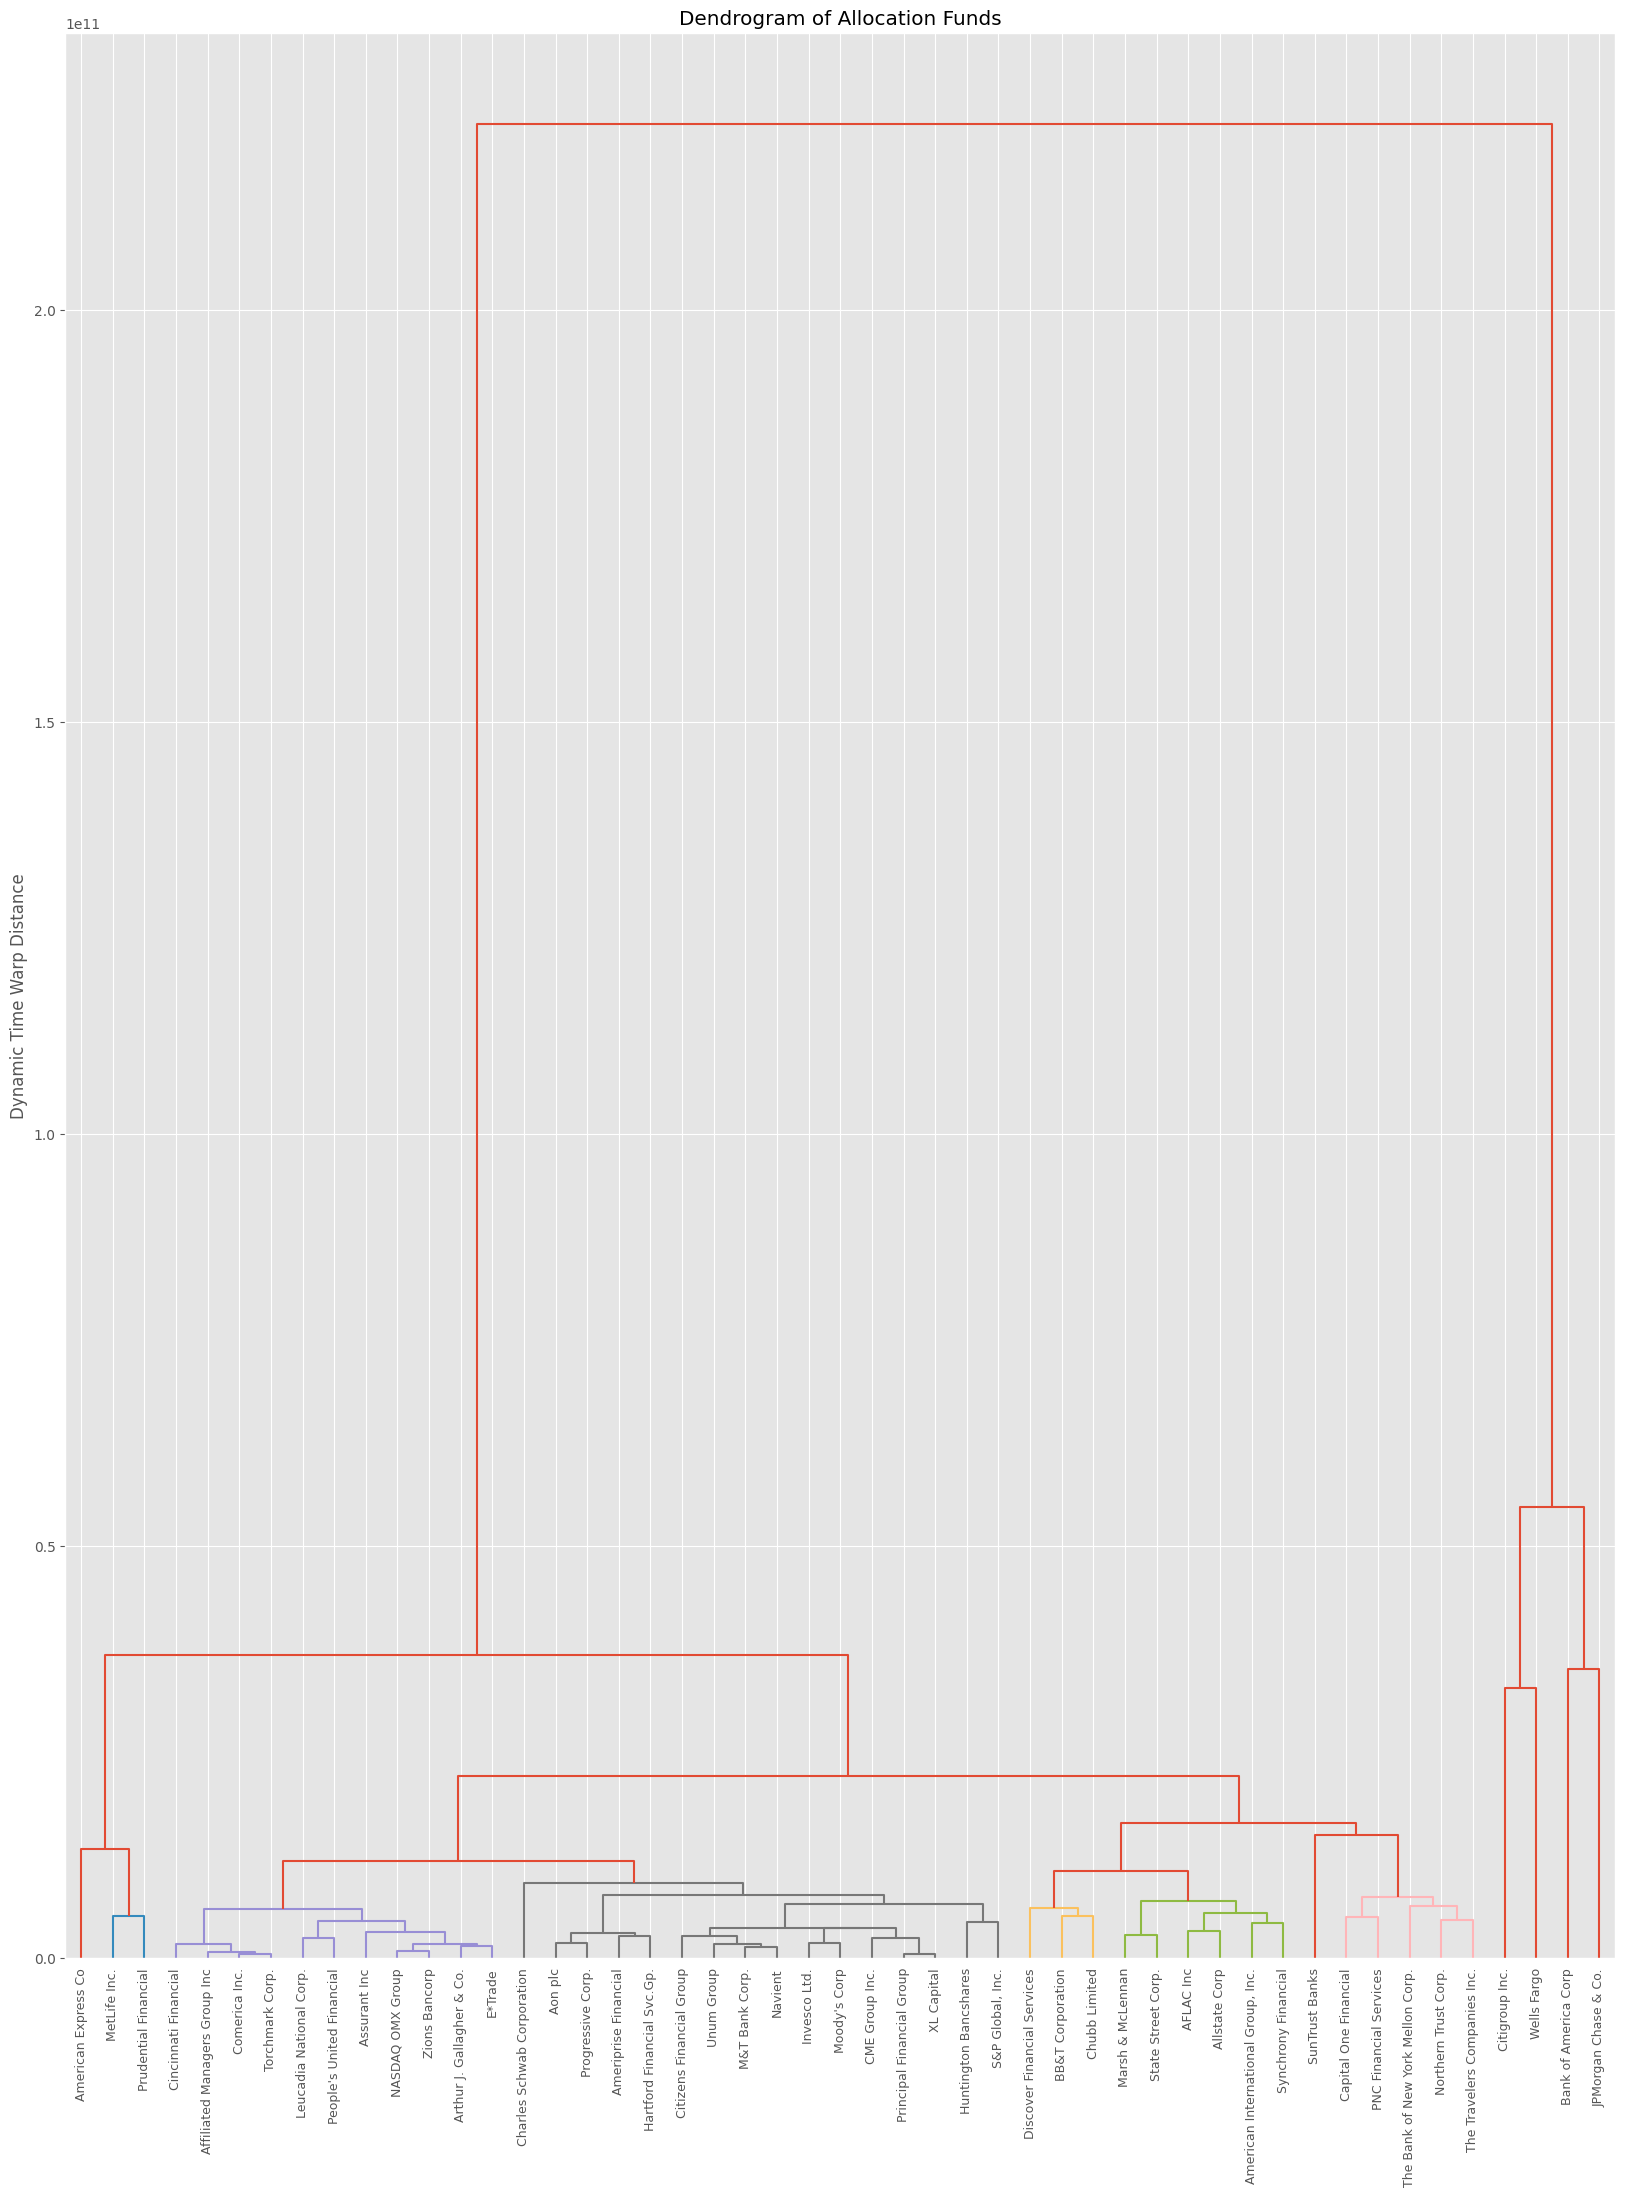

In [16]:
# Using scipy's dendrogram function plot the linkages as
# a hierachical tree.
fig, ax = plt.subplots(1,1,figsize=(20, 25))
ax.set_title('Dendrogram of Allocation Funds')
ax.set_ylabel('Dynamic Time Warp Distance')
dendro = dendrogram(link, color_threshold=1e10, leaf_font_size=9,labels=funds_financial['Security'].values)

In [17]:
max_d = 1e10
clusters = fcluster(link, max_d, criterion='distance')

funds_financial = funds_financial.sort_values('Security')
inpt = sorted([(clusters[i],dendro['ivl'][i]) for i in range(len(clusters))], key=lambda x: x[1])[:]
funds_financial['cluster'] = list(zip(*inpt))[0]

for cluster in range(1,len(np.unique(clusters))+1):
    df_seg=funds_financial[funds_financial['cluster']==cluster]
    values, counts = np.unique(df_seg['GICS Sub Industry'],return_counts=True)
    print('Cluster {} categories:'.format(cluster))
    print('# funds in category: {}'.format(sum(counts)))
    print(list(zip(values, counts)))
    print()

Cluster 1 categories:
# funds in category: 2
[('Property & Casualty Insurance', 2)]

Cluster 2 categories:
# funds in category: 1
[('Thrifts & Mortgage Finance', 1)]

Cluster 3 categories:
# funds in category: 11
[('Asset Management & Custody Banks', 1), ('Banks', 2), ('Diversified Financial Services', 2), ('Financial Exchanges & Data', 1), ('Insurance Brokers', 2), ('Property & Casualty Insurance', 2), ('Regional Banks', 1)]

Cluster 4 categories:
# funds in category: 16
[('Asset Management & Custody Banks', 2), ('Banks', 4), ('Consumer Finance', 3), ('Diversified Financial Services', 3), ('Investment Banking & Brokerage', 1), ('Life & Health Insurance', 2), ('Multi-Sector Holdings', 1)]

Cluster 5 categories:
# funds in category: 3
[('Diversified Financial Services', 1), ('Investment Banking & Brokerage', 1), ('Regional Banks', 1)]

Cluster 6 categories:
# funds in category: 6
[('Asset Management & Custody Banks', 1), ('Banks', 3), ('Consumer Finance', 1), ('Life & Health Insurance',

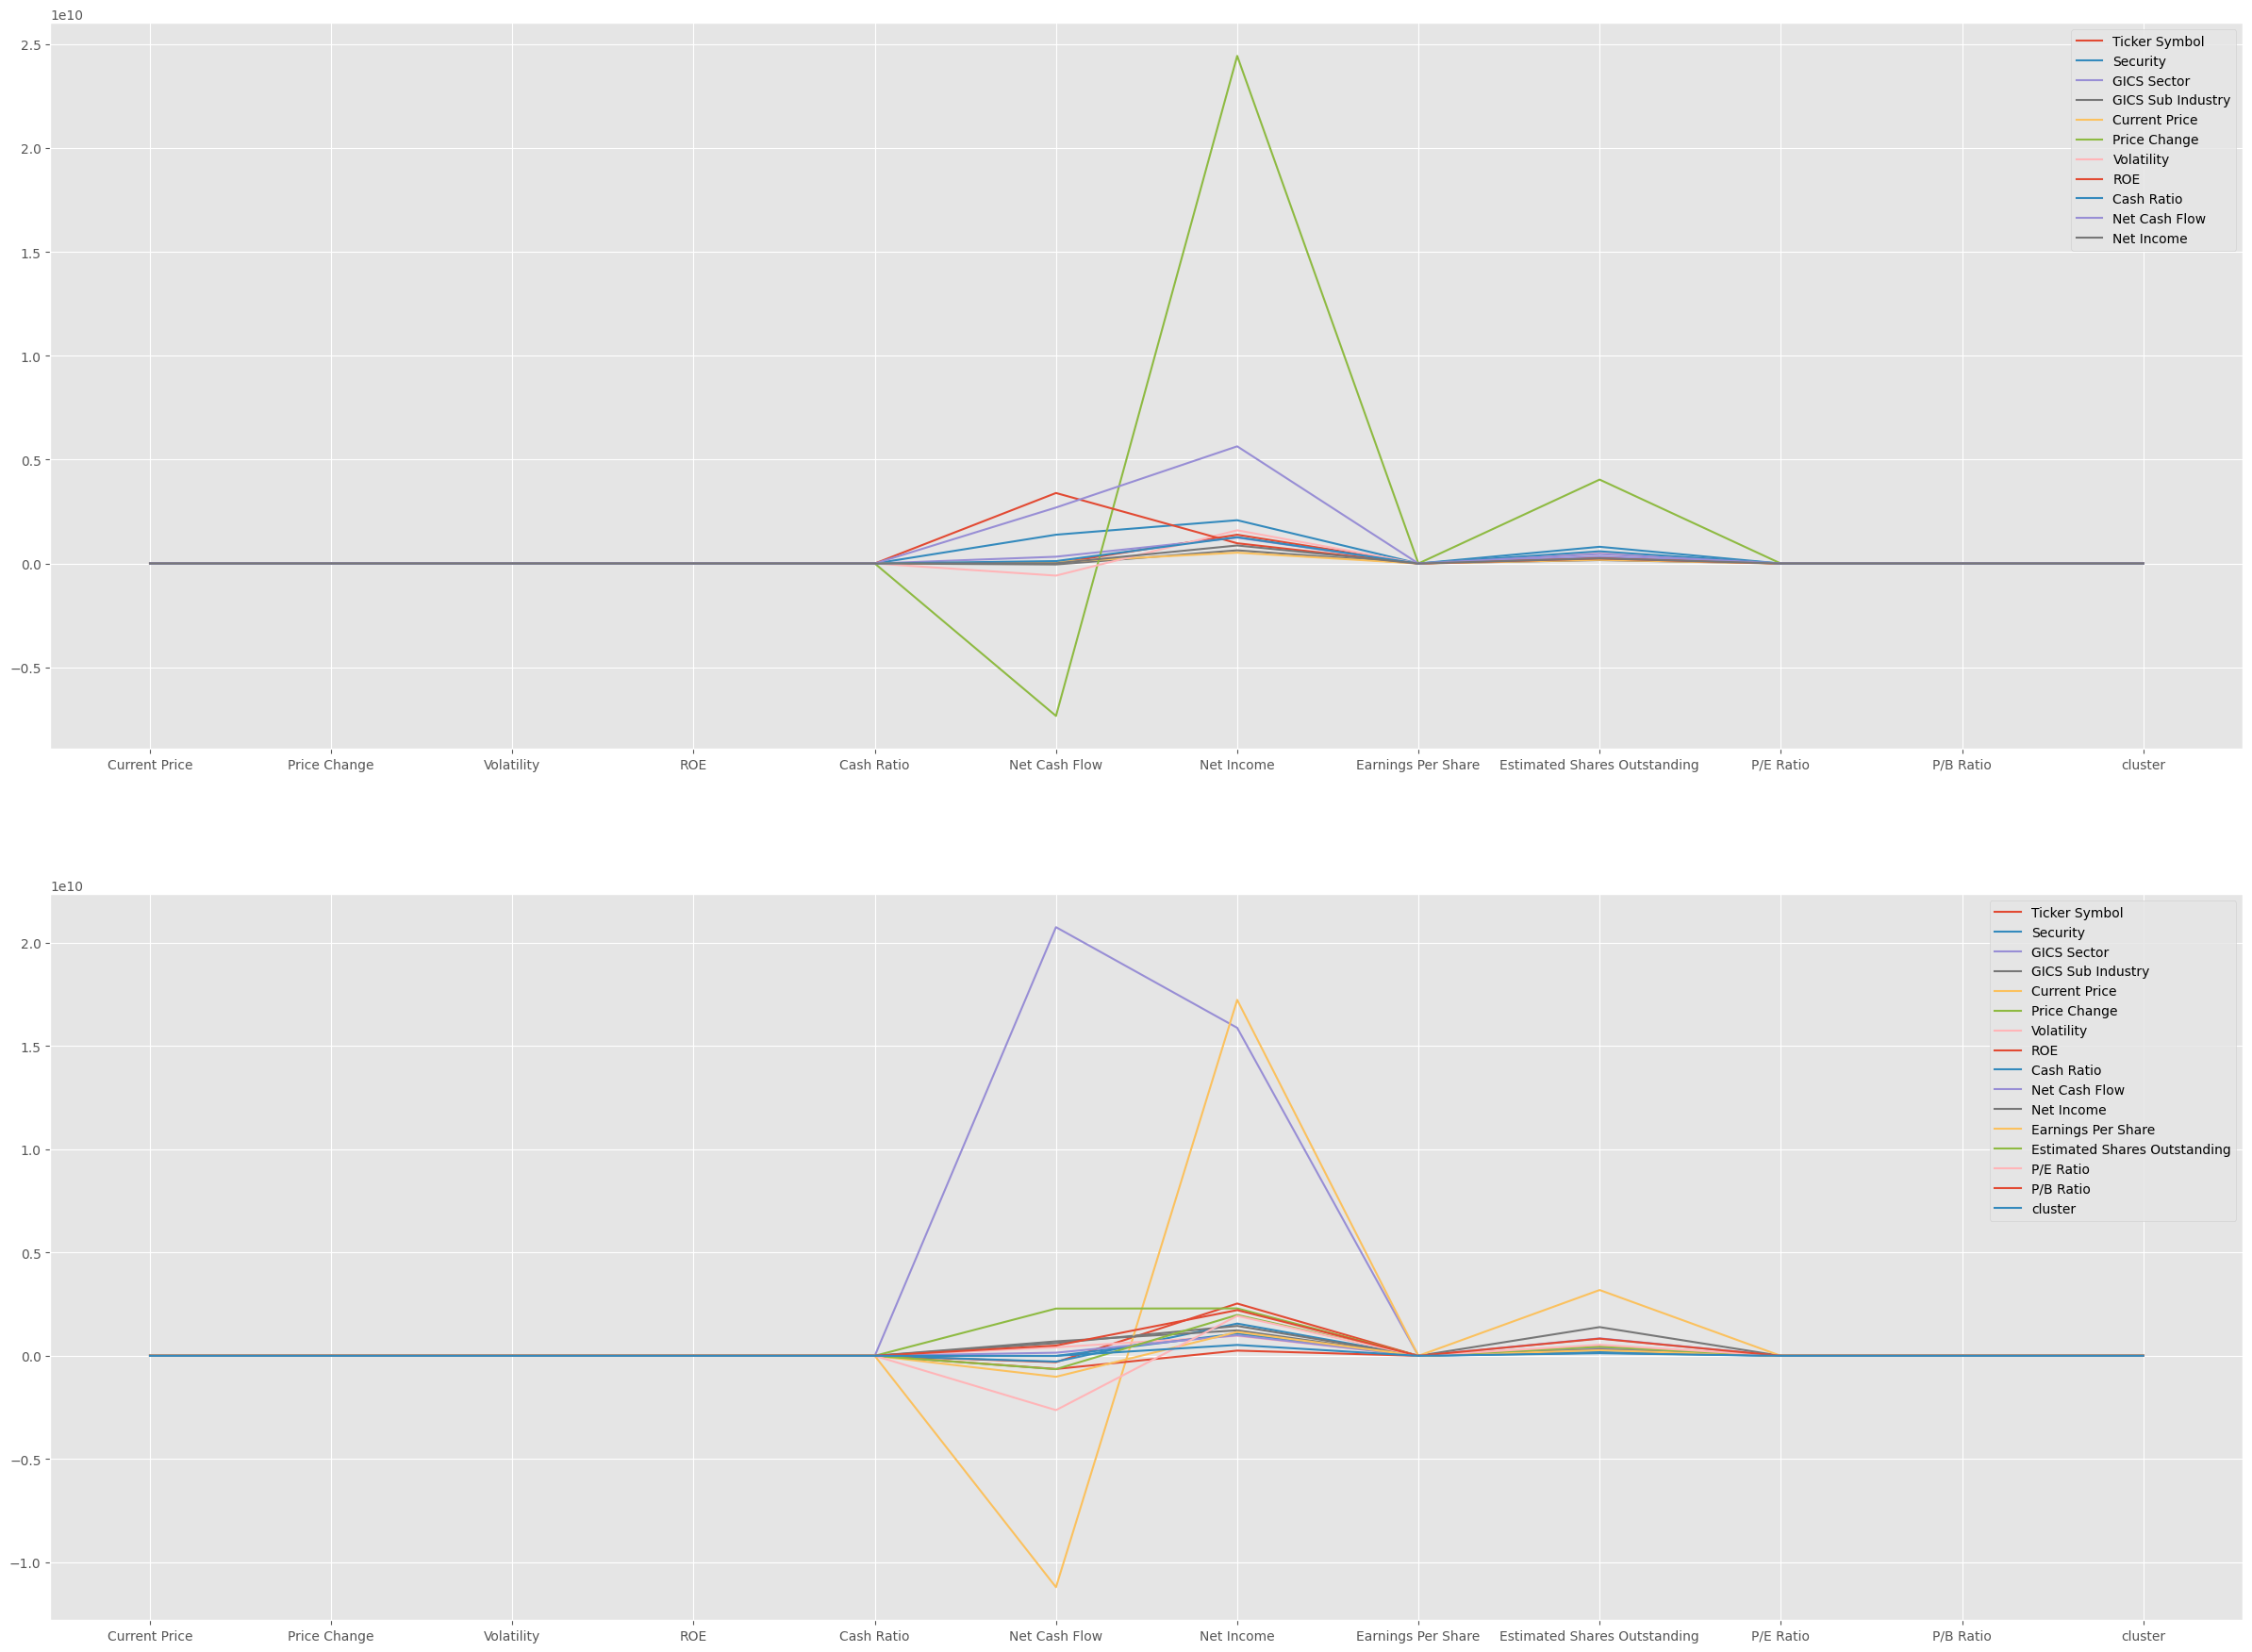

In [18]:
# plot all the funds in clusters 3 & 4
cluster3 = funds_financial[funds_financial['cluster']==3]
cluster4 = funds_financial[funds_financial['cluster']==4]
fig, ax = plt.subplots(2,1,figsize=(30,22))

for i in range(cluster3.shape[0]):
    y = cluster3.iloc[i,4:].values
    x = cluster3.columns[4:]
    ax[0].plot(x,y,label=cluster3.columns[i])
    ax[0].legend()
    
for i in range(cluster4.shape[0]):
    y = cluster4.iloc[i,4:].values
    x = cluster4.columns[4:]
    ax[1].plot(x,y,label=cluster4.columns[i])
    ax[1].legend()

In [20]:
def scree_plot(pca, title=None):
    num_components = pca.n_components_
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
    plt.figure(figsize=(10, 6), dpi=250)
    ax = plt.subplot(111)
    ax.bar(ind, vals, 0.35,
           color=[(0.949, 0.718, 0.004),
                  (0.898, 0.49, 0.016),
                  (0.863, 0, 0.188),
                  (0.694, 0, 0.345),
                  (0.486, 0.216, 0.541),
                  (0.204, 0.396, 0.667),
                  (0.035, 0.635, 0.459),
                  (0.486, 0.722, 0.329),
                 ])

    for i in np.arange(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)

    ax.set_xticklabels(ind,
                       fontsize=12)

    ax.set_ylim(0, max(vals)+0.05)
    ax.set_xlim(0-0.45, 8+0.45)

    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)

    ax.set_xlabel("Principal Component", fontsize=12)
    ax.set_ylabel("Variance Explained (%)", fontsize=12)

    if title is not None:
        plt.title(title, fontsize=16)

<ipython-input-20-87e760754eb6>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ind,


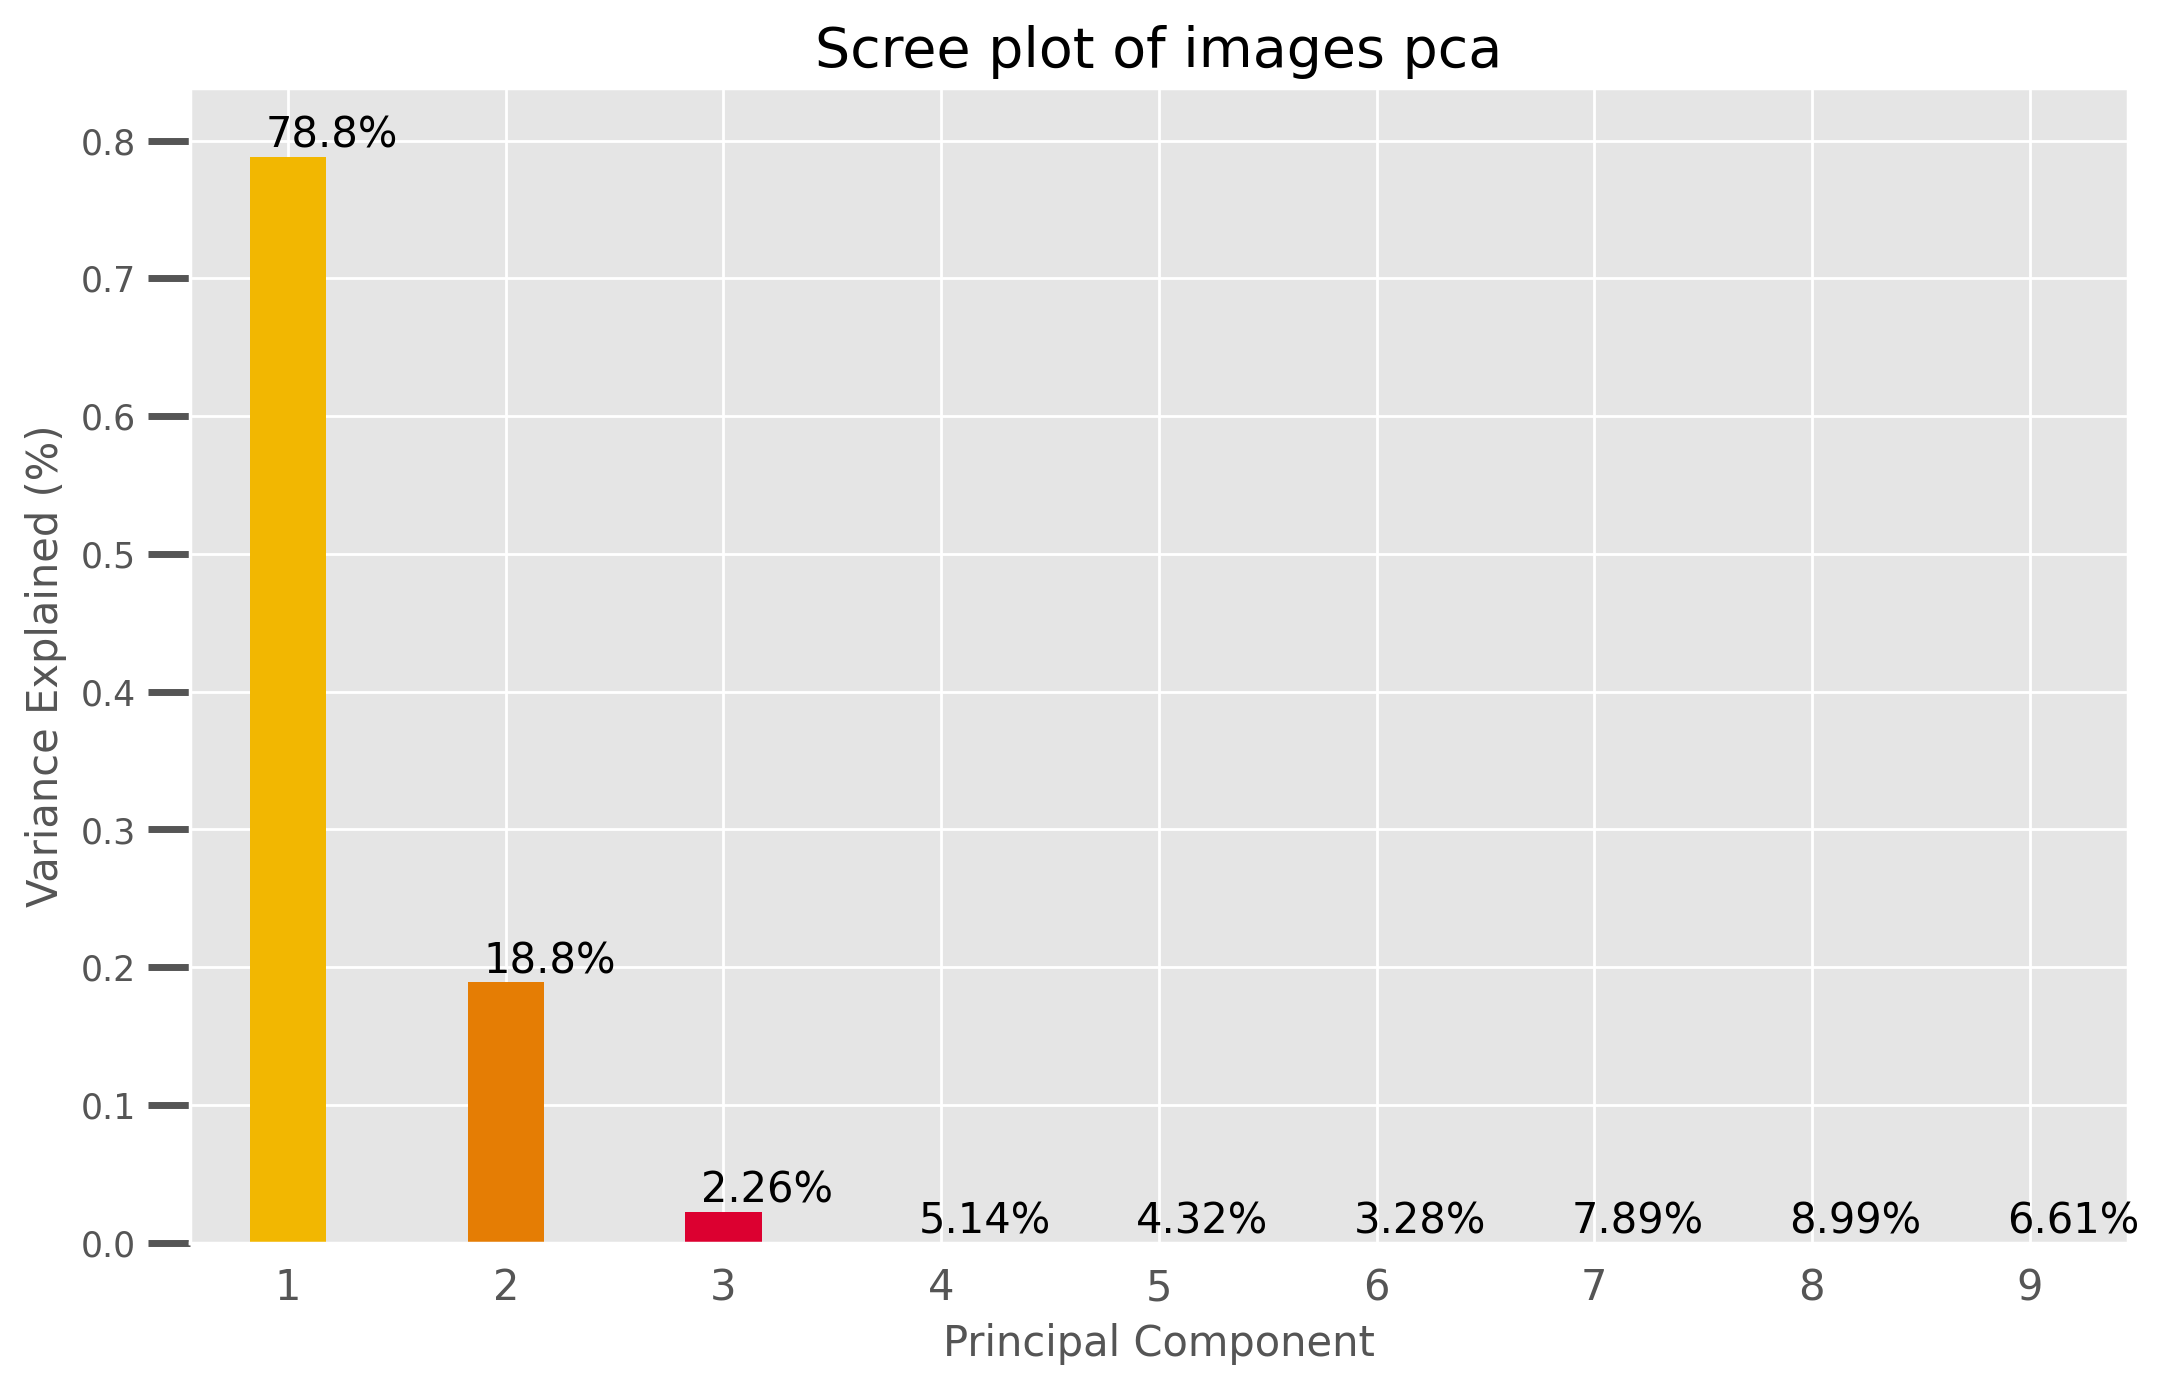

In [21]:
pca = PCA(n_components=10)
data_pca = pca.fit_transform(data)
scree_plot(pca, title = 'Scree plot of images pca')

In [35]:
tsne_5 = TSNE(n_components=2, perplexity = 5)
data_tsne5 = tsne_5.fit_transform(data)
df_tsne5 = pd.DataFrame(data_tsne5, columns = ['tsne_one','tsne_two'])
df_tsne5['GICS Sub Industry'] = funds_financial['GICS Sub Industry']

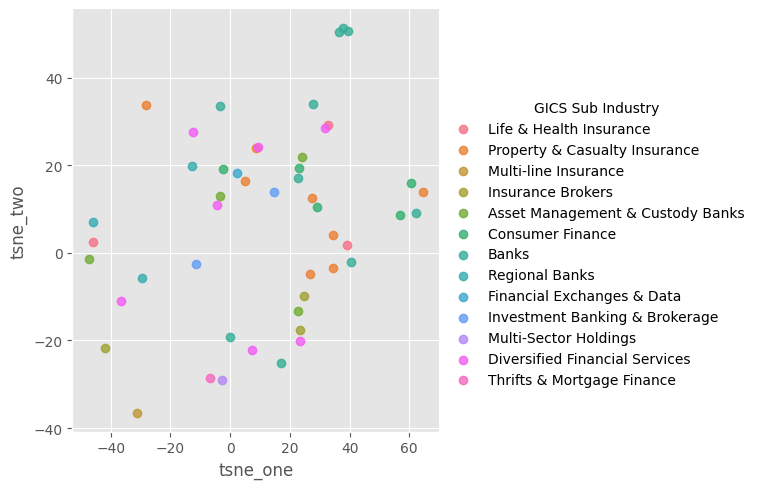

In [38]:
sns.lmplot(x='tsne_one', y ='tsne_two', data = df_tsne5 , fit_reg=False, legend=True, hue = 'GICS Sub Industry')
plt.title='Perplexity 5'

In [39]:
tsne_10 = TSNE(n_components=2, perplexity = 10)
data_tsne10 = tsne_10.fit_transform(data)
df_tsne10 = pd.DataFrame(data_tsne10, columns = ['tsne_one','tsne_two'])
df_tsne10['GICS Sub Industry'] = funds_financial['GICS Sub Industry']

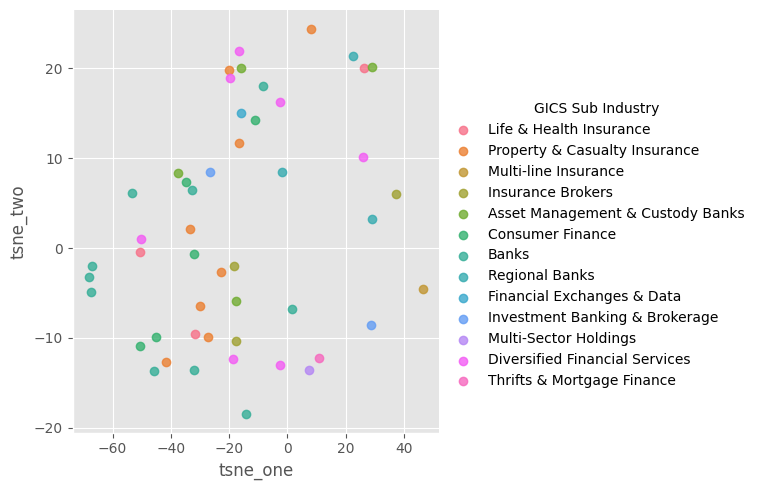

In [40]:
sns.lmplot(x='tsne_one', y ='tsne_two', data = df_tsne10 , fit_reg=False, legend=True, hue = 'GICS Sub Industry')
plt.title='Perplexity 10'

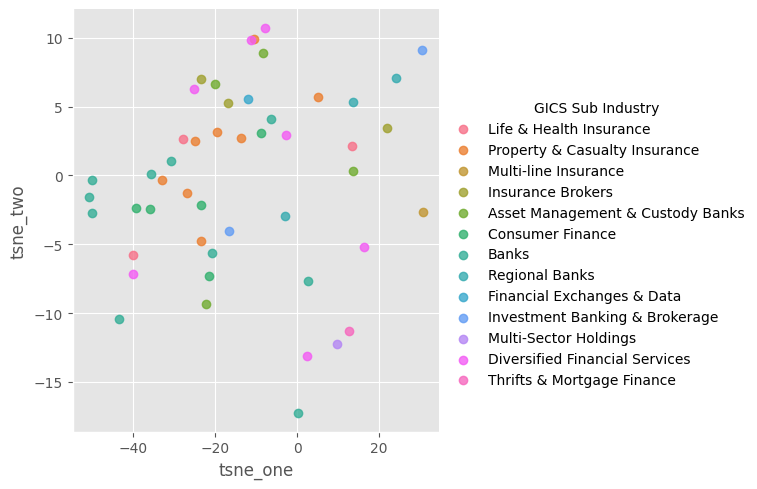

In [41]:
tsne_20 = TSNE(n_components=2, perplexity = 20)
data_tsne20 = tsne_20.fit_transform(data)
df_tsne20 = pd.DataFrame(data_tsne20, columns = ['tsne_one','tsne_two'])
df_tsne20['GICS Sub Industry'] = funds_financial['GICS Sub Industry']
sns.lmplot(x='tsne_one', y ='tsne_two', data = df_tsne20 , fit_reg=False, legend=True, hue = 'GICS Sub Industry')
plt.title='Perplexity 20'

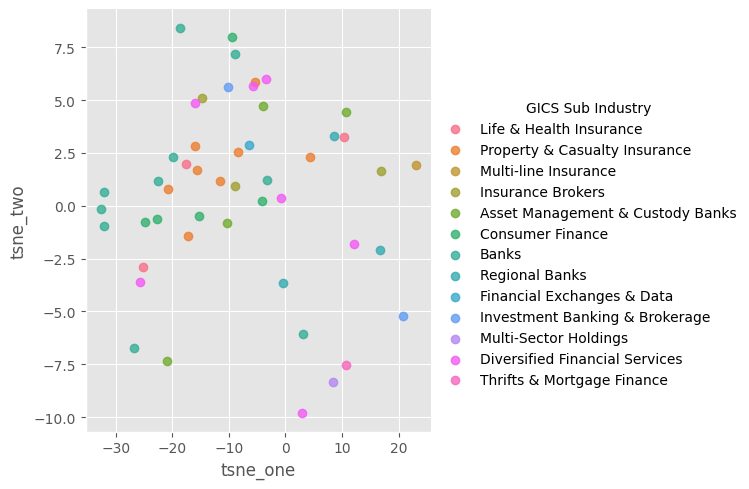

In [43]:
tsne_30 = TSNE(n_components=2, perplexity = 30)
data_tsne30 = tsne_30.fit_transform(data)
df_tsne30 = pd.DataFrame(data_tsne30, columns = ['tsne_one','tsne_two'])
df_tsne30['GICS Sub Industry'] = funds_financial['GICS Sub Industry']
sns.lmplot(x='tsne_one', y ='tsne_two', data = df_tsne30 , fit_reg=False, legend=True, hue = 'GICS Sub Industry') 
plt.title='Perplexity 30'

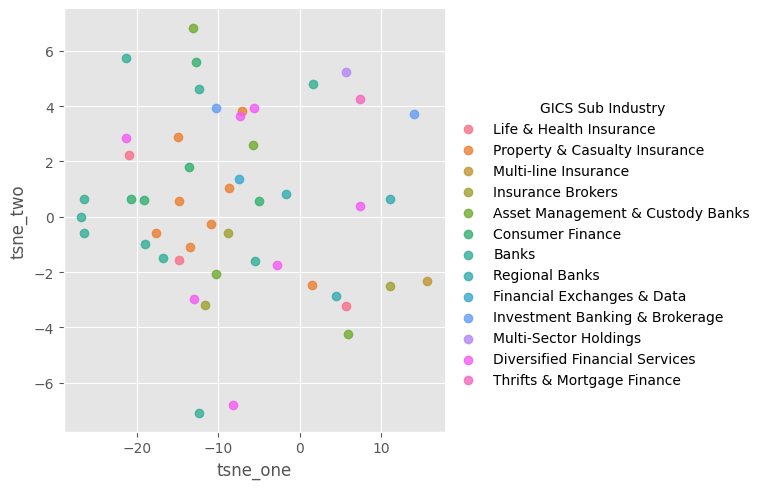

In [44]:
tsne_40 = TSNE(n_components=2, perplexity = 40)
data_tsne40 = tsne_40.fit_transform(data)
df_tsne40 = pd.DataFrame(data_tsne40, columns = ['tsne_one','tsne_two'])
df_tsne40['GICS Sub Industry'] = funds_financial['GICS Sub Industry']
sns.lmplot(x='tsne_one', y ='tsne_two', data = df_tsne40 , fit_reg=False, legend=True, hue = 'GICS Sub Industry')
plt.title='Perplexity 40'

In [105]:
dbs = DBSCAN(eps=1e9)
dbs.fit(data)

DBSCAN(eps=1000000000.0)

In [106]:
np.unique(dbs.labels_)

array([-1,  0,  1])

In [107]:
'''
Find tsne for numerical columns
Output: assign for self.df_tsne a copy of input dataframe with
tsne columns appended
'''
tsne3 = TSNE(n_components = 3)
df_tsne3 = funds_financial.copy()
#use only the numeric columns
numerical_df = df_tsne3.select_dtypes(include=[np.number])

tsne_result3 = tsne3.fit_transform(numerical_df.values)

In [108]:
df_tsne3['tsne_one'] = tsne_result3[:,0]
df_tsne3['tsne_two'] = tsne_result3[:,1]
df_tsne3['tsne_three'] = tsne_result3[:,2]
df_tsne3.head()

,Ticker Symbol,Security,GICS Sector,GICS Sub Industry,Current Price,Price Change,Volatility,ROE,Cash Ratio,Net Cash Flow,Net Income,Earnings Per Share,Estimated Shares Outstanding,P/E Ratio,P/B Ratio,cluster,tsne_one,tsne_two,tsne_three
9,AFL,AFLAC Inc,Financials,Life & Health Insurance,59.900002,3.027181,1.048295,14,99,-308000000,2533000000,5.88,4.307823e+08,10.187075,-1.883912,4,-80.168259,97.131203,17.466761
22,AMG,Affiliated Managers Group Inc,Financials,Asset Management & Custody Banks,159.759995,-6.611335,2.093065,18,67,13200000,516000000,9.49,5.437302e+07,16.834562,-31.015380,6,-50.226021,-89.446991,66.593803
17,ALL,Allstate Corp,Financials,Property & Casualty Insurance,62.090000,6.592275,1.053266,11,99,-162000000,2171000000,5.12,4.240234e+08,12.126953,-4.327138,7,-0.430517,12.807019,-107.535339
38,AXP,American Express Co,Financials,Consumer Finance,69.550003,-6.216290,0.900066,25,99,474000000,5163000000,3.90,5.066604e+08,10.263506,-0.609074,6,-20.968731,-83.927925,-73.065750
10,AIG,"American International Group, Inc.",Financials,Property & Casualty Insurance,61.970001,8.358108,1.106965,2,99,-129000000,2196000000,1.69,1.299408e+09,36.668640,-4.327138,1,51.327946,-25.881121,-67.304405


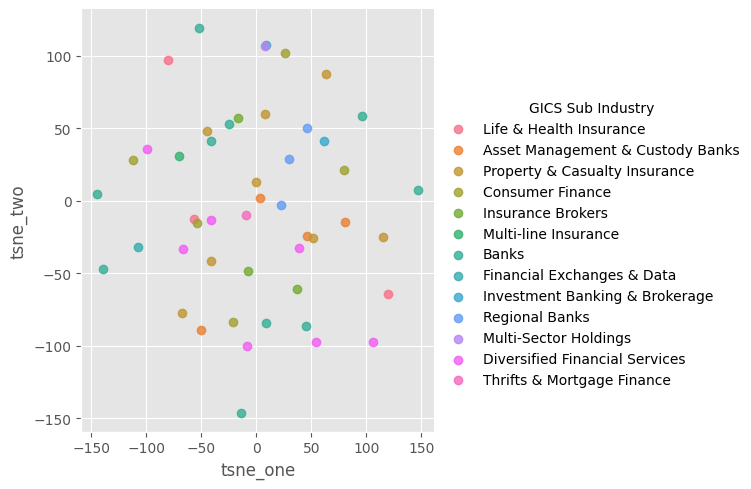

In [110]:
sns.lmplot(x='tsne_one', y ='tsne_two', data = df_tsne3, hue = 'GICS Sub Industry', fit_reg=False)

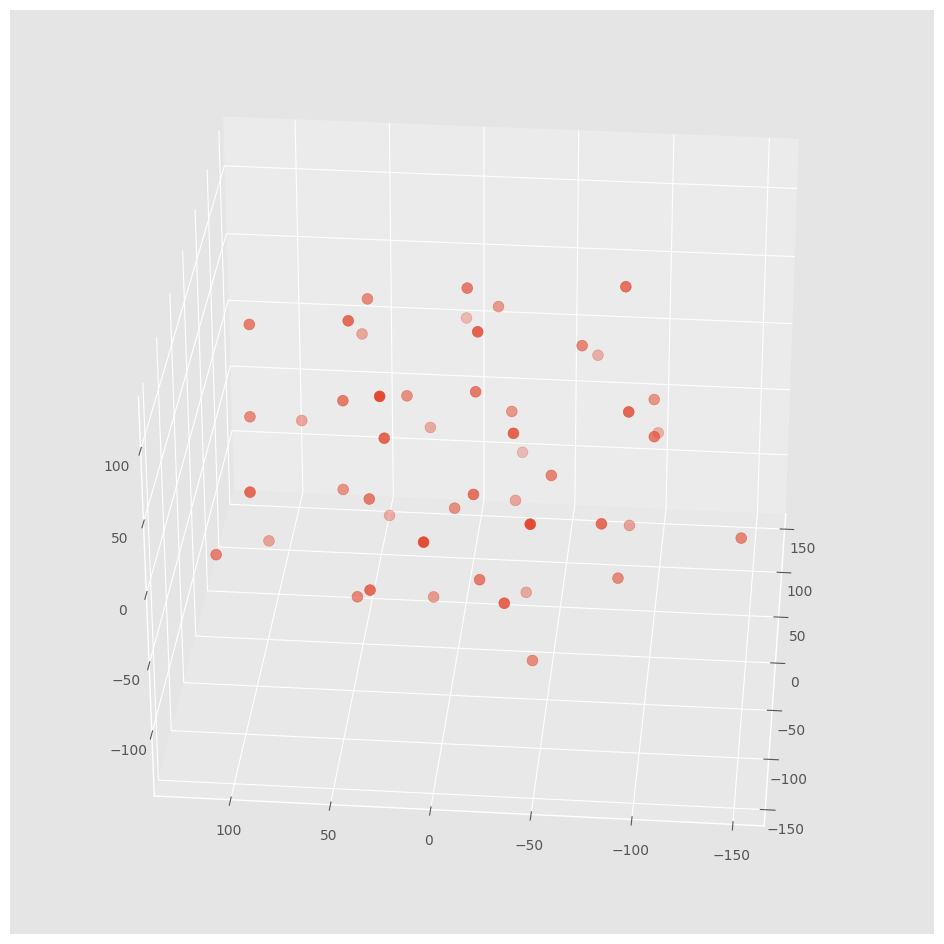

In [132]:
from mpl_toolkits.mplot3d import Axes3D
# plot
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
colors = df_tsne3['GICS Sub Industry'].values
ax.scatter(df_tsne3['tsne_one'], df_tsne3['tsne_two'], df_tsne3['tsne_three'], s=60)
ax.view_init(30, 185)
plt.show()

In [113]:
funds_financial.head()
def make_pct_change(df, list_col_names_to_change):
    # Filter the dataframe to just the columns to change
    df=df.copy()
    df_to_change = df.loc[:,list_col_names_to_change]
    num_columns = df_to_change.shape[1]
    
    # got through columns t+1 to end
    for col_idx in np.arange(1,num_columns):
        col_name = ('{} % Change'.format(df_to_change.iloc[:,col_idx].name))
        df[col_name]=(df_to_change.iloc[:,col_idx]-df_to_change.iloc[:,col_idx-1])/df_to_change.iloc[:,col_idx-1]
    
    return df

In [112]:
funds_financial.columns

Index(['Ticker Symbol', 'Security', 'GICS Sector', 'GICS Sub Industry',
       'Current Price', 'Price Change', 'Volatility', 'ROE', 'Cash Ratio',
       'Net Cash Flow', 'Net Income', 'Earnings Per Share',
       'Estimated Shares Outstanding', 'P/E Ratio', 'P/B Ratio', 'cluster'],
      dtype='object')

In [122]:
df_funds_pct_change = make_pct_change(funds_financial, ['Current Price','Price Change','Volatility','ROE','Net Cash Flow','Net Income','Earnings Per Share',
       'Estimated Shares Outstanding', 'P/E Ratio', 'P/B Ratio','Cash Ratio'])
# drop the raw columns
df_funds_pct_change.drop(['Current Price','Price Change','Volatility','ROE','Net Cash Flow','Net Income','Earnings Per Share',
       'Estimated Shares Outstanding', 'P/E Ratio', 'P/B Ratio','Cash Ratio','cluster'], axis=1, inplace=True)
# deal with infinite and nan entries caused by dividing by 0 or a very small amount
df_funds_pct_change.replace([np.inf, -np.inf], np.nan, inplace=True)
df_funds_pct_change.fillna(0, inplace=True)
df_funds_pct_change

,Ticker Symbol,Security,GICS Sector,GICS Sub Industry,Price Change % Change,Volatility % Change,ROE % Change,Net Cash Flow % Change,Net Income % Change,Earnings Per Share % Change,Estimated Shares Outstanding % Change,P/E Ratio % Change,P/B Ratio % Change,Cash Ratio % Change
9,AFL,AFLAC Inc,Financials,Life & Health Insurance,-0.949463,-0.653706,12.355023,-2.200000e+07,-9.224026,-1.0,7.326230e+07,-1.000000,-1.184932,-53.550225
22,AMG,Affiliated Managers Group Inc,Financials,Asset Management & Custody Banks,-1.041383,-1.316587,7.599827,7.333323e+05,38.090909,-1.0,5.729506e+06,-1.000000,-2.842363,-3.160219
17,ALL,Allstate Corp,Financials,Property & Casualty Insurance,-0.893827,-0.840227,9.443705,-1.472727e+07,-14.401235,-1.0,8.281708e+07,-1.000000,-1.356820,-23.878862
38,AXP,American Express Co,Financials,Consumer Finance,-1.089379,-1.144792,26.775735,1.896000e+07,9.892405,-1.0,1.299129e+08,-1.000000,-1.059344,-163.541957
10,AIG,"American International Group, Inc.",Financials,Property & Casualty Insurance,-0.865127,-0.867558,0.806741,-6.450000e+07,-18.023256,-1.0,7.688806e+08,-1.000000,-1.118007,-23.878862
24,AMP,Ameriprise Financial,Financials,Asset Management & Custody Banks,-1.022747,-1.504923,16.999451,-1.277273e+07,-6.558719,-1.0,2.111952e+07,-1.000000,-2.082748,-6.000605
29,AON,Aon plc,Financials,Insurance Brokers,-0.957594,-0.717405,19.813873,4.347816e+05,137.500000,-1.0,5.698439e+07,-1.000000,-1.414880,-13.757969
13,AJG,Arthur J. Gallagher & Co.,Financials,Insurance Brokers,-1.014825,-2.733358,8.505249,1.660000e+07,1.149398,-1.0,8.326915e+07,-1.000000,-1.498322,-11.044942
12,AIZ,Assurant Inc,Financials,Multi-line Insurance,-0.976437,-0.413732,1.696377,-1.011700e+07,-5.663932,-1.0,3.271889e+07,-0.999999,-1.105178,-25.308705
42,BBT,BB&T Corporation,Financials,Banks,-0.842898,-0.818574,6.423364,1.732500e+08,0.503608,-1.0,3.106692e+08,-1.000000,-1.058401,-117.120535


In [123]:
df_funds_pct_change.describe()

,Price Change % Change,Volatility % Change,ROE % Change,Net Cash Flow % Change,Net Income % Change,Earnings Per Share % Change,Estimated Shares Outstanding % Change,P/E Ratio % Change,P/B Ratio % Change,Cash Ratio % Change
count,49.000000,49.000000,49.000000,4.900000e+01,49.000000,4.900000e+01,4.900000e+01,4.900000e+01,49.000000,49.000000
mean,-0.914295,-1.059356,21.783599,3.800671e+07,8.389027,-1.000000e+00,2.354294e+08,-9.999999e-01,-1.282731,-196.956149
std,0.194146,0.833660,79.238276,5.576439e+08,92.562028,3.321781e-09,3.105093e+08,9.019089e-08,0.515573,426.590374
min,-1.821896,-4.815497,0.286806,-1.401000e+09,-204.059432,-1.000000e+00,5.729506e+06,-1.000000e+00,-3.401653,-1570.036239
25%,-1.002986,-1.108743,4.563524,-2.336000e+07,-5.397906,-1.000000e+00,6.068795e+07,-1.000000e+00,-1.413649,-118.394086
50%,-0.908895,-0.840227,7.583247,4.347816e+05,-0.404444,-1.000000e+00,9.059800e+07,-1.000000e+00,-1.122055,-51.764184
75%,-0.848542,-0.717405,10.206608,5.391538e+07,1.731481,-1.000000e+00,3.106692e+08,-9.999999e-01,-1.055887,-13.757969
max,-0.498472,0.194023,550.413948,3.460667e+09,572.166667,-1.000000e+00,1.337833e+09,-9.999994e-01,-0.156535,20.240578


In [124]:
tsne_pct = TSNE(n_components = 2)
df_tsne_pct = df_funds_pct_change.copy()
#use only the numeric columns
numerical_df = df_tsne_pct.select_dtypes(include=[np.number])

tsne_result_pct = tsne_pct.fit_transform(numerical_df.values)

In [125]:
df_tsne_pct['tsne_one'] = tsne_result_pct[:,0]
df_tsne_pct['tsne_two'] = tsne_result_pct[:,1]
df_tsne_pct.head()

,Ticker Symbol,Security,GICS Sector,GICS Sub Industry,Price Change % Change,Volatility % Change,ROE % Change,Net Cash Flow % Change,Net Income % Change,Earnings Per Share % Change,Estimated Shares Outstanding % Change,P/E Ratio % Change,P/B Ratio % Change,Cash Ratio % Change,tsne_one,tsne_two
9,AFL,AFLAC Inc,Financials,Life & Health Insurance,-0.949463,-0.653706,12.355023,-2.200000e+07,-9.224026,-1.0,7.326230e+07,-1.0,-1.184932,-53.550225,-3.214506,0.976484
22,AMG,Affiliated Managers Group Inc,Financials,Asset Management & Custody Banks,-1.041383,-1.316587,7.599827,7.333323e+05,38.090909,-1.0,5.729506e+06,-1.0,-2.842363,-3.160219,-2.893207,1.952223
17,ALL,Allstate Corp,Financials,Property & Casualty Insurance,-0.893827,-0.840227,9.443705,-1.472727e+07,-14.401235,-1.0,8.281708e+07,-1.0,-1.356820,-23.878862,-3.040218,0.872287
38,AXP,American Express Co,Financials,Consumer Finance,-1.089379,-1.144792,26.775735,1.896000e+07,9.892405,-1.0,1.299129e+08,-1.0,-1.059344,-163.541957,-2.488794,0.564101
10,AIG,"American International Group, Inc.",Financials,Property & Casualty Insurance,-0.865127,-0.867558,0.806741,-6.450000e+07,-18.023256,-1.0,7.688806e+08,-1.0,-1.118007,-23.878862,-2.472333,-2.000321


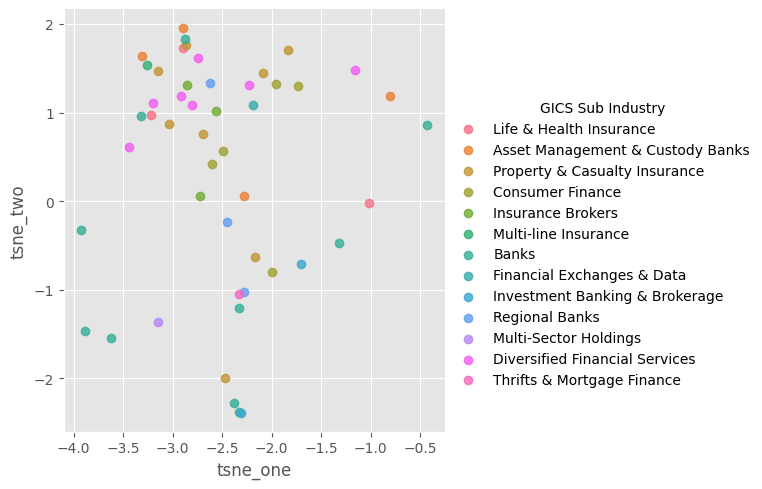

In [130]:
sns.lmplot(x='tsne_one', y ='tsne_two', data = df_tsne_pct, hue = 'GICS Sub Industry', fit_reg=False, legend=True)